## Libraries

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.regression.linear_model import OLS
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as datetime
import itertools
from itertools import product
from bayes_opt import BayesianOptimization
import yfinance as yf
from scipy.stats import skew, kurtosis
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.volume import OnBalanceVolumeIndicator
from ta.volume import AccDistIndexIndicator
from statsmodels.tsa.stattools import acf
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer

import json
import pickle

In [4]:
import os
pd.set_option('future.no_silent_downcasting', True)

## Load the optimised parameters for strategies and their respective returns (saved dataframes and dictionaries)

In [6]:
def convert_string_keys_to_tuples(d):
    return {tuple(key.split('-')): value for key, value in d.items()}

# load the JSON files (dictionaries)
with open('pair_strats_best_params.json', 'r') as f:
    loaded_pair_strats_best_params = json.load(f)
with open('others_strats_best_params.json', 'r') as f:
    loaded_other_strats_best_params = json.load(f)
with open('macd_strats_best_params.json', 'r') as f:
    loaded_macd_strats_best_params = json.load(f)

# convert string keys back to tuples
pair_strats_best_params_tuple_keys = {
    outer_key: convert_string_keys_to_tuples(inner_dict)
    for outer_key, inner_dict in loaded_pair_strats_best_params.items()
}

# load individual dictionaries
test_pairs_all_best_params = pair_strats_best_params_tuple_keys['test_pairs_all_best_params']
test_sma_all_best_params = loaded_other_strats_best_params['test_sma_all_best_params']
test_macd_all_best_params = loaded_macd_strats_best_params['test_macd_all_best_params']

with open('macd_strats_best_params.json', 'r') as f:
    loaded_macd_strats_best_params = json.load(f)

# load DataFrames
test_benchmark_strat_df = pd.read_pickle('test_benchmark_strat_df.pkl')
benchmark_strat_df = pd.read_pickle('benchmark_strat_df.pkl')
test_otpimized_pairs_strat_df = pd.read_pickle('test_otpimized_pairs_strat_df.pkl')
test_otpimized_sma_stocks_df = pd.read_pickle('test_otpimized_sma_stocks_df.pkl')
test_optimized_macd_stocks_df = pd.read_pickle('test_optimized_macd_stocks_df.pkl')

## Data Cleaning

In [8]:
def clean_data(file):
    raw = pd.read_csv(file, header=1, index_col=0)
    data = raw.iloc[1:, :].copy()
    # reformat and clean dataset
    data.rename_axis("Date", inplace=True)
    data.index = pd.to_datetime(data.index, format="%d/%m/%Y")
    
    data.dropna(inplace=True) # last 2 rows NaN values dropped
    # rename all columns according to metrics
    metrics = ["Close", "Dividends", "High", "Low", "Open", "Stock Splits", "Volume"]
    columns = data.columns
    new_columns = {}
    for col in columns:
      if '.' in col:
        stock, suffix = col.split('.')
        metric_index = int(suffix)
        new_columns[col] = f"{stock}_{metrics[metric_index]}"
      else:
        new_columns[col] = f"{col}_Close"
    data.rename(columns=new_columns, inplace=True)
    return data

### Trading period data (1 March 2024 to 16 January 2025)

In [10]:
file = 'Trading_Project_Data.csv'
data = clean_data(file).iloc[:, :20].copy() # extract close prices from cleaned data
data = data.loc['2024-03-01':] # trading period data
stocks = list(set([col.split("_")[0] for col in data.columns]))
stocks.sort()
for stock in stocks:
    data.rename(columns={f'{stock}_Close': f'{stock}'}, inplace=True)

### Training period data (17 January 2023 to 17 January 2024)

In [12]:
test = yf.Tickers(stocks)
test_data = test.history(start = '2023-01-17', end = '2024-01-17')
columns_to_drop = ['High', 'Low', 'Open', 'Dividends', 'Stock Splits']
test_data.drop(columns=columns_to_drop, inplace=True)
test_vol = test_data.iloc[:,-20:].copy()
test_vol.columns = test_vol.columns.droplevel(0)

test_data = test_data.iloc[:,:20].copy()
test_data.columns = test_data.columns.droplevel(0)

[*********************100%***********************]  20 of 20 completed


## Benchmark strategy

In [14]:
def benchmark_strategy(data, stock, rf = 0.04):
    df = pd.DataFrame(index=data.index, columns=['Returns', 'Cumulative Returns'])
    df['Returns'] = np.log(data[stock]/data[stock].shift(1)).fillna(0)
    df['Cumulative Returns'] = df['Returns'].cumsum()
    total_return = np.exp(df['Cumulative Returns'].iloc[-1]) - 1
    annualized_return = np.mean((np.exp(df['Returns']) - 1)) * 252
    daily_volatility = np.std(df['Returns'])
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = np.where(annualized_volatility != 0,
                        (annualized_return - rf) / annualized_volatility,
                        0)
    
    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio}
    
    return metrics, df

## MACD strategy

In [16]:
def macd_strat(data, stock, fast_period, slow_period, signal_period, rf=0.04):
    stock_df = data[[stock]].copy()
    stock_df.rename(columns={stock: 'Close'}, inplace=True)

    # calculate daily log returns
    stock_df['Log_Returns'] = np.log(stock_df['Close'] / stock_df['Close'].shift(1))

    # calculate MACD and signal line
    stock_df['EMA_fast'] = stock_df['Close'].ewm(span=fast_period, adjust=False).mean()
    stock_df['EMA_slow'] = stock_df['Close'].ewm(span=slow_period, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_fast'] - stock_df['EMA_slow']
    stock_df['Signal_Line'] = stock_df['MACD'].ewm(span=signal_period, adjust=False).mean()
    stock_df = stock_df.fillna(0)

    # generate signals: 1 for long, -1 for short, 0 for no position
    stock_df['Signal'] = np.where(stock_df['MACD'] > stock_df['Signal_Line'], 1, 0)
    stock_df['Signal'] = np.where(stock_df['MACD'] < stock_df['Signal_Line'], -0.5, stock_df['Signal'])

    # detect when a trade occurs (position change)
    stock_df['Action'] = stock_df.Signal.diff().fillna(0)

    # calculate strategy returns
    stock_df['MACD_Returns'] = stock_df['Log_Returns'] * stock_df['Signal'].shift(1)
    stock_df['MACD_Returns'] = stock_df['MACD_Returns'].fillna(0)

    # total simple return
    total_return = np.exp(stock_df['MACD_Returns'].sum()) - 1

    # performance metrics
    annualized_return = np.mean(np.exp(stock_df['MACD_Returns']) - 1) * 252
    daily_volatility = np.std(np.exp(stock_df['MACD_Returns']) - 1)
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = np.where(annualized_volatility != 0, (annualized_return - rf) / annualized_volatility, 0)
    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio}

    return metrics, stock_df


def plot_macd(stock_df, stock):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # plot 1: MACD Line, signal line, and trading actions
    ax1.plot(stock_df.index, stock_df['MACD'].where(stock_df['MACD'] != 0), label='MACD Line', color='blue')
    ax1.plot(stock_df.index, stock_df['Signal_Line'].where(stock_df['Signal_Line'] != 0), label='Signal Line', color='orange')
    ax1.plot(stock_df[stock_df.Action == 1.5].index, stock_df['MACD'][stock_df.Action == 1.5], '^', color='lime', markersize=12, label='Buy Signal')
    ax1.plot(stock_df[stock_df.Action == -1.5].index, stock_df['MACD'][stock_df.Action == -1.5], 'v', color='red', markersize=12, label='Sell Signal')

    ax1.set_title(f'{stock} MACD Strategy Trading Signals')
    ax1.set_ylabel('MACD')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)

    # plot 2: cumulative returns (comparison with benchmark strategy (buy and hold)
    ax2.plot(stock_df.index, np.exp(stock_df['MACD_Returns'].cumsum()), label='MACD Strategy', color='red')
    ax2.plot(stock_df.index, np.exp(stock_df['Log_Returns'].cumsum()), label='Benchmark (Buy & Hold)', color='blue')

    ax2.set_title(f'{stock} Cumulative Returns: MACD Strategy vs Benchmark')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Return')
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    
# find parameters values for slow, fast and signal period or MACD strat that maximises returns for each stock
def macd_bayes_opt(data, stock, fast_range=(5, 20), slow_range=(21, 50), signal_range=(5, 20), init_points=5, n_iter=50):
    # bounds for the params in the opt process
    pbounds = {'fast_period': fast_range, 'slow_period': slow_range, 'signal_period': signal_range}

    def objective(fast_period, slow_period, signal_period):  # objective function for bayes opt
        metrics, _ = macd_strat(data, stock, fast_period=int(fast_period), slow_period=int(slow_period), signal_period=int(signal_period))
        return metrics['total_return']

    # perform bayes opt
    optimizer = BayesianOptimization(f=objective,  # target function to maximise
                                     pbounds=pbounds,  # param bounds
                                     random_state=42)

    # optimize the params
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

    # extract optimized params and total return
    best_fast = int(optimizer.max['params']['fast_period']) # round to integer
    best_slow = int(optimizer.max['params']['slow_period']) # round to integer
    best_signal = int(optimizer.max['params']['signal_period']) # round to integer
    best_total_return = optimizer.max['target']

    return best_fast, best_slow, best_signal, best_total_return

## SMA strategy

In [18]:
def sma_strat(data, stock, short_window, long_window, rf=0.04):
    stock_df = data[[f'{stock}']].copy()
    stock_df.rename(columns={f'{stock}': 'Close'}, inplace=True)
    stock_df = data[[stock]].copy()
    
    # calculate daily log returns
    stock_df['Log_Returns'] = np.log(stock_df[stock] / stock_df[stock].shift(1))

    # calculate moving averages
    stock_df['Short_SMA'] = stock_df[stock].rolling(window=short_window).mean()
    stock_df['Long_SMA'] = stock_df[stock].rolling(window=long_window).mean()
    stock_df = stock_df.fillna(0)

    # generate signals: 1 for long, -1 for short, 0 for no position
    stock_df['Signal'] = np.where(stock_df['Short_SMA'] > stock_df['Long_SMA'], 1, 0)
    stock_df['Signal'] = np.where(stock_df['Short_SMA'] < stock_df['Long_SMA'], -0.5, stock_df['Signal'])

    # detect when a trade occurs (position change)
    stock_df['Action'] = stock_df.Signal.diff().fillna(0)

    # calculate strategy returns
    stock_df['SMA_Returns'] = stock_df['Log_Returns'] * stock_df['Signal'].shift(1)
    stock_df['SMA_Returns'] = stock_df['SMA_Returns'].fillna(0)

    # total simple return
    total_return = np.exp(stock_df['SMA_Returns'].sum()) - 1

    # performance metrics
    annualized_return = np.mean(np.exp(stock_df['SMA_Returns']) - 1) * 252
    daily_volatility = np.std(np.exp(stock_df['SMA_Returns']) - 1)
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = np.where(annualized_volatility != 0, (annualized_return - rf) / annualized_volatility, 0)

    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio}

    return metrics, stock_df


def plot_sma(stock_df, stock):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # plot 1: stock price series, SMAs, and signals
    ax1.plot(stock_df.index, stock_df[stock], label=f'{stock} Price', color='blue')
    ax1.plot(stock_df.index, stock_df['Short_SMA'].where(stock_df['Short_SMA'] != 0), label='Short SMA', color='orange')
    ax1.plot(stock_df.index, stock_df['Long_SMA'].where(stock_df['Long_SMA'] != 0), label='Long SMA', color='green')
    ax1.plot(stock_df[stock_df.Action == 1.5].index, stock_df['Short_SMA'][stock_df.Action == 1.5], '^', color='lime', markersize=12, label='Buy Signal')
    ax1.plot(stock_df[stock_df.Action == -1.5].index, stock_df['Short_SMA'][stock_df.Action == -1.5], 'v', color='red', markersize=12, label='Sell Signal')
    ax1.set_title(f'{stock} SMA Strategy Trading Signals')
    ax1.set_ylabel('Stock Price')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)

    # plot 2: cumulative returns (comparison with benchmark strategy (buy and hold)
    ax2.plot(stock_df.index, np.exp(stock_df['SMA_Returns'].cumsum()), label='SMA Strategy', color='red')
    ax2.plot(stock_df.index, np.exp(stock_df['Log_Returns'].cumsum()), label='Benchmark (Buy & Hold)', color='blue')

    ax2.set_title(f'{stock} Cumulative Returns: SMA Strategy vs Benchmark')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Return')
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


# find parameters values for short and long window size for SMA strat that maximises returns for each stock
def sma_bayes_opt(data, stock, short_range=(5, 50), long_range=(51, 200), init_points = 5, n_iter = 50):
    # bounds for the params in the opt process
    pbounds = {'short_window': short_range, 'long_window': long_range}

    def objective(short_window, long_window): # objective function for bayes opt
        metrics, _ = sma_strat(data, stock, int(short_window), int(long_window))
        return metrics['total_return']

    # perform bayes opt
    optimizer = BayesianOptimization(f=objective,  # target function to maximise
                                     pbounds=pbounds,  # params bounds
                                     random_state=42)
    
    # optimize the params
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

    # extract optimized params and total return
    best_short = int(optimizer.max['params']['short_window']) # round to integer
    best_long = int(optimizer.max['params']['long_window'])  # round to integer
    best_total_return = optimizer.max['target']

    return best_short, best_long, best_total_return

## Pairs strategy

In [20]:
def cointegration_test(data, threshold):
    stock_pairs = itertools.combinations(data.columns, 2) # get all pairs of stocks
    cointegrated_pairs = []
    p_values = []

    for stock2, stock1 in stock_pairs:
        X = sm.add_constant(data[stock1]) # regress stock2 (DV) on stock1 (IV)
        model = OLS(data[stock2], X).fit()
        residuals = data[stock2] - model.predict() # errors from regression (spread)
        # test residuals for stationarity using a unit root test -> Augmented Dickey-Fuller test
        adf_test = adfuller(residuals)
        p_value = adf_test[1]
        if p_value < threshold: # residuals are stationary, stock1 and stock2 are cointegrated
            cointegrated_pairs.append((stock1, stock2))
            p_values.append(p_value)

    return cointegrated_pairs, p_values


def pairs_strat(data, pair, window, entry_threshold, exit_threshold, rf=0.04):
    stock1, stock2 = pair
    
    # compute zscore for the pair
    X = sm.add_constant(data[stock1])
    model = sm.OLS(data[stock2], X).fit()
    spread = data[stock2] - model.predict(X) # calculate the spread as residuals
    # rolling mean and std of spread
    spread_mean = spread.rolling(window=window).mean()
    spread_std = spread.rolling(window=window).std()
    zscore = (spread - spread_mean) / spread_std
    zscore = zscore.fillna(0)

    # apply pairs trading strat
    # initialise DataFrame to store positions and returns for the pair
    pair_df = pd.DataFrame(index=zscore.index, columns=[f'{stock1} Position', f'{stock2} Position', f'{stock1} Returns', f'{stock2} Returns', 'zscore', f'{stock1} Action', f'{stock2} Action'])

    # initialise positions and returns as 0 both for stocks for the start
    pair_df.iloc[:, :] = 0

    # generate daily entry and exit signals (positions)
    for i in pair_df.index[1:]:
        current_zscore = zscore.loc[i]
        pair_df.loc[i, 'zscore'] = current_zscore
            
        # zscore < -entry_threshold and no existing long position for stock 1
        if (current_zscore < -entry_threshold) & (pair_df[f'{stock1} Position'].shift(1).at[i] == 0):
            pair_df.loc[i, f'{stock1} Position'] = 1  # long stock 1
            pair_df.loc[i, f'{stock2} Position'] = -0.5 # short stock 2
            pair_df.loc[i, f'{stock1} Action'] = 1
            pair_df.loc[i, f'{stock2} Action'] = -0.5
            
        # zscore > entry_threshold and no existing short position for stock 2
        elif (current_zscore > entry_threshold) & (pair_df[f'{stock2} Position'].shift(1).at[i] == 0):
            pair_df.loc[i, f'{stock1} Position'] = -0.5  # short stock 1
            pair_df.loc[i, f'{stock2} Position'] = 1   # long stock 2
            pair_df.loc[i, f'{stock1} Action'] = -0.5
            pair_df.loc[i, f'{stock2} Action'] = 1

        # -exit_threshold < zscore < exit_threshold
        elif abs(current_zscore) < exit_threshold:
            pair_df.loc[i, f'{stock1} Position'] = 0  # exit position in stock 1
            pair_df.loc[i, f'{stock2} Position'] = 0  # exit position in stock 2
            
            if pair_df[f'{stock1} Position'].shift(1).at[i] == 1: # exit long
                pair_df.loc[i, f'{stock1} Action'] = -1
            if pair_df[f'{stock1} Position'].shift(1).at[i] == -0.5: # exit short
                pair_df.loc[i, f'{stock1} Action'] = 0.5

            if pair_df[f'{stock2} Position'].shift(1).at[i] == 1: # exit long
                pair_df.loc[i, f'{stock2} Action'] = -1
            if pair_df[f'{stock2} Position'].shift(1).at[i] == -0.5: # exit short
                pair_df.loc[i, f'{stock2} Action'] = 0.5
                
        # -entry_threshold < zscore < -exit_threshold or exit_threshold < zscore < entry_threshold
        else:
            pair_df.loc[i, f'{stock1} Position'] = pair_df[f'{stock1} Position'].shift(1).at[i] # maintain existing position in stock 1
            pair_df.loc[i, f'{stock2} Position'] = pair_df[f'{stock2} Position'].shift(1).at[i] # maintain existing position in stock 2

        # calculate daily (log) returns for each stock based on the positions
        pair_df.loc[i, f'{stock1} Returns'] = (np.log(data.loc[i, stock1] / data[stock1].shift(1).at[i])) * pair_df[f'{stock1} Position'].shift(1).loc[i]
        pair_df.loc[i, f'{stock2} Returns'] = (np.log(data.loc[i, stock2] / data[stock2].shift(1).at[i])) * pair_df[f'{stock2} Position'].shift(1).loc[i]

    if pair_df.empty or len(pair_df) < window:
        return {'total_return': 0, 'other_metrics': None}, pair_df
        
    # calculate combined (log) return, (log) cumulative return and total (simple) return
    pair_df['combined_returns'] =  pair_df[f'{stock1} Returns'] + pair_df[f'{stock2} Returns']
    pair_df['combined_returns'] = pair_df['combined_returns'].astype(float)
    pair_df['cumulative_combined_returns'] = pair_df['combined_returns'].cumsum()
    total_return = np.exp(pair_df['cumulative_combined_returns'].iloc[-1]) - 1
    annualized_return = np.mean((np.exp(pair_df['combined_returns']) - 1)) * 252
    daily_volatility = np.std(pair_df['combined_returns'])
    annualized_volatility = daily_volatility * np.sqrt(252)

    sharpe_ratio = np.where(annualized_volatility != 0, (annualized_return - rf) / annualized_volatility, 0)

    metrics = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio}

    return metrics, pair_df


def plot_pairs(pair_df, pair, entry_threshold, exit_threshold):
    stock1, stock2 = pair
    stock1_log_rets = np.log(data[stock1] / data[stock1].shift(1)).fillna(0)
    stock2_log_rets = np.log(data[stock2] / data[stock2].shift(1)).fillna(0)
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 18))
    
    # plot 1: zscore and signals for stock 1
    axes[0].plot(pair_df.index, pair_df['zscore'], label='Z-Score', color='blue')
    axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[0].axhline(entry_threshold, color='red', linestyle='--', linewidth=1, label='Entry Threshold')
    axes[0].axhline(-entry_threshold, color='green', linestyle='--', linewidth=1, label='Entry Threshold')
    axes[0].axhline(exit_threshold, color='orange', linestyle=':', linewidth=1, label='Exit Threshold')
    axes[0].axhline(-exit_threshold, color='orange', linestyle=':', linewidth=1)

    # plot signals for stock 1
    axes[0].scatter(pair_df[(pair_df[f'{stock1} Action']) == 1].index, 
                    pair_df['zscore'][(pair_df[f'{stock1} Action']) == 1], 
                    marker='^', color='lime', s=120, label=f'{stock1} Entry Long')

    axes[0].scatter(pair_df[(pair_df[f'{stock1} Action']) == -0.5].index, 
                    pair_df['zscore'][(pair_df[f'{stock1} Action']) == -0.5], 
                    marker='v', color='red', s=120, label=f'{stock1} Entry Short')

    axes[0].scatter(pair_df[(pair_df[f'{stock1} Action']) == -1].index, 
                    pair_df['zscore'][(pair_df[f'{stock1} Action']) == -1], 
                    marker='x', color='orange', s=100, label=f'{stock1} Exit Long')

    axes[0].scatter(pair_df[(pair_df[f'{stock1} Action']) == 0.5].index, 
                    pair_df['zscore'][(pair_df[f'{stock1} Action']) == 0.5], 
                    marker='x', color='purple', s=100, label=f'{stock1} Exit Short')

    axes[0].set_title(f'{stock1} Pairs Trading Signals')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Z-Score')
    axes[0].legend(loc='best')
    axes[0].grid(alpha=0.3)

    # plot 2: zscore and signals for stock 2
    axes[1].plot(pair_df.index, pair_df['zscore'], label='Z-Score', color='blue')
    axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[1].axhline(entry_threshold, color='red', linestyle='--', linewidth=1, label='Entry Threshold')
    axes[1].axhline(-entry_threshold, color='green', linestyle='--', linewidth=1, label='Entry Threshold')
    axes[1].axhline(exit_threshold, color='orange', linestyle=':', linewidth=1, label='Exit Threshold')
    axes[1].axhline(-exit_threshold, color='orange', linestyle=':', linewidth=1)

    # Entry and Exit signals for stock 2
    axes[1].scatter(pair_df[(pair_df[f'{stock2} Action']) == 1].index, 
                    pair_df['zscore'][(pair_df[f'{stock2} Action']) == 1], 
                    marker='^', color='lime', s=120, label=f'{stock1} Entry Long')

    axes[1].scatter(pair_df[(pair_df[f'{stock2} Action']) == -0.5].index, 
                    pair_df['zscore'][(pair_df[f'{stock2} Action']) == -0.5], 
                    marker='v', color='red', s=120, label=f'{stock1} Entry Short')


    axes[1].scatter(pair_df[(pair_df[f'{stock2} Action']) == -1].index, 
                    pair_df['zscore'][(pair_df[f'{stock2} Action']) == -1], 
                    marker='x', color='orange', s=100, label=f'{stock2} Exit Long')

    axes[1].scatter(pair_df[(pair_df[f'{stock2} Action']) == 0.5].index, 
                    pair_df['zscore'][(pair_df[f'{stock2} Action']) == 0.5], 
                    marker='x', color='purple', s=100, label=f'{stock2} Exit Short')

    axes[1].set_title(f'{stock2} Pairs Trading Signals')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Z-Score')
    axes[1].legend(loc='best')
    axes[1].grid(alpha=0.3)

    # plot 3: cumulative returns (comparison with benchmark strategy (buy and hold)
    axes[2].plot(stock_df.index, np.exp(pair_df['cumulative_combined_returns']), label = 'Pairs Strategy', color='red')
    axes[2].plot(np.exp(stock1_log_rets.cumsum()), label=f'{stock1} Benchmark')
    axes[2].plot(np.exp(stock2_log_rets.cumsum()), label=f'{stock2} Benchmark')
    axes[2].set_title(f'Cumulative returns for {stock1}-{stock2} pairs')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Cumulative Return')
    axes[2].legend(loc='best')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# find parameters values for window, entry and exit for pairs strat that maximises the total returns of the strat (for each pair)
def pairs_bayes_opt(data, pair, window_range = (5, 50), entry_range=(1.5, 3), exit_range=(0, 1), init_points = 5, n_iter = 50):
    pbounds = {'window': window_range, 'entry_threshold': entry_range, 'exit_threshold': exit_range}
    
    def objective(window, entry_threshold, exit_threshold):
        metrics, _ = pairs_strat(data, pair, window=int(window),
 entry_threshold=entry_threshold, exit_threshold=exit_threshold)
        return metrics['total_return']

    # perform bayes opt
    optimizer = BayesianOptimization(f=objective, # target function to maximise
                                     pbounds=pbounds, # params bounds
                                     random_state=42)
    
    # optimize the params
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

    
    # extract optimized params and total return
    best_window = int(optimizer.max['params']['window']) # round to integer
    best_entry = optimizer.max['params']['entry_threshold']
    best_exit = optimizer.max['params']['exit_threshold']
    best_total_return = optimizer.max['target']
    
    return best_window, best_entry, best_exit, best_total_return

In [21]:
test_cointegrated_pairs, test_p_values = cointegration_test(test_data, threshold=0.05)

## Linear Regression strategy

In [23]:
volume = clean_data(file).iloc[:,-20:].copy()
volume.columns = stocks

features = ['EMA', 'RSI', 'MACD', 'OBV', 'Lag_1','Lag_2','Lag_3','Lag_4','Lag_5']

In [24]:
def compute_indicators(data, volume, stock):
    close = data[[stock]].copy()
    close.columns = ['Close']
    close['Volume'] = volume[stock].copy()
    close['Return'] = close['Close'].pct_change()
    close['Log_Returns'] = np.log(close['Close']/close['Close'].shift())
    close['Volume_Lag'] = close['Volume'].shift()
    close.fillna(0, inplace=True)
    close['SMA_10'] = close['Close'].rolling(window=10).mean().shift()
    close['SMA_20'] = close['Close'].rolling(window=20).mean().shift()
    close['EMA'] = close['Close'].ewm(min_periods = 12, alpha = 0.7,adjust=False).mean().shift()
    close['RSI'] = RSIIndicator(close['Close'], window=14).rsi().shift()
    close['MACD'] = (close['Close'].ewm(span=12, adjust=False).mean() - close['Close'].ewm(span=26, adjust=False).mean()).shift()
    close['BB_High'] = BollingerBands(close['Close']).bollinger_hband().shift()
    close['BB_Low'] = BollingerBands(close['Close']).bollinger_lband().shift()
    close['Bollinger_Width'] = BollingerBands(close['Close']).bollinger_wband().shift()
    close['Volatility'] = close['Log_Returns'].rolling(window=5).std().shift()
    close['Skewness'] = close['Log_Returns'].rolling(window=5).apply(skew, raw= True).shift()
    close['Kurtosis'] = close['Log_Returns'].rolling(window=5).apply(kurtosis, raw= True).shift()
    close['OBV'] = OnBalanceVolumeIndicator(close['Close'], close['Volume']).on_balance_volume().shift()
    
    # target
    close['Direction'] = np.sign(close['Log_Returns']).astype(int)
    return close

def create_lags(stock):
    # Create lagged features
    num_lags = 20  # Test different values
    for i in range(1, num_lags + 1):
        stock[f'Lag_{i}'] = stock['Log_Returns'].shift(i)

    stock.dropna(inplace=True)  # Drop NaN values

    
def select_lags_logreg(stock, num_lags):
    
    X = stock[[f'Lag_{i}' for i in range(1, num_lags + 1)]]
    y = stock['Direction']  # Binary direction (1 = up, 0 = down)

    # Recursive Feature Elimination
    model = LogisticRegression(random_state=42)
    selector = RFE(model, n_features_to_select=5)
    selector.fit(X, y)

    selected_features = [f'Lag_{i}' for i, selected in enumerate(selector.support_, 1) if selected]
    return selected_features


def sliding_window_linear_reg(df, train_data, features, train_size=63, test_size=21):
    # Uses 3-month training window to predict the next month, retrains the model every month
    predictions = []
    r2_scores = []  # Store R-squared scores
    
    current_data = train_data.copy()
    
    for i in range(0, len(df), test_size):
        # Define training and testing data
        test_data = df.iloc[i:i + test_size]

        # Initialize scalers for training and test data
        train_scaler = MinMaxScaler()
        test_scaler = MinMaxScaler()
        
        # Scale the training data
        scaled_data = train_scaler.fit_transform(current_data[features])
        # Scale the test data using the training scaler
        test_scaler.fit(current_data[features])
        scaled_test = test_scaler.transform(test_data[features])
        
        # Split the training and testing data
        X_train = scaled_data
        y_train = current_data['Log_Returns']  # Use 'Log_Returns' for continuous target variable
        X_test = scaled_test
        y_test = test_data['Log_Returns']  # Same for the test set
        
        # Initialize the Linear Regression model
        model = LinearRegression()
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        # Calculate the R-squared score
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        

        # Add predictions txo the list
        predictions.extend(y_pred)
        
        # Update the current data for the next iteration
        current_data = pd.concat((current_data, test_data))
        if len(current_data) > train_size:
            current_data = current_data.iloc[len(current_data) - train_size:]

    predictions = np.array(predictions)
    predictions = np.where(predictions < np.percentile(predictions, 10), -0.5, 1)
    return predictions, r2_scores


def lin_reg_strat(data, volume, ticker, train_end, test_start, sliding_window_strat, features = ['SMA_10', 'EMA_5', 'Volatility', 'Skewness', 'Kurtosis', 'Lag_1', 'Lag_2', 'Lag_4', 'Lag_8', 'Lag_16'], plot=True):
    stock = compute_indicators(data, volume, ticker)
    create_lags(stock)
    train = stock.loc[:train_end].copy()
    test = stock.loc[test_start:].copy()
    
    pred, acc = sliding_window_strat(test, train, features)
    test['Returns_LinReg'] = (pred* test['Log_Returns'])
    
    if plot:
        rets = test['Returns_LinReg'].cumsum().apply(np.exp)
        bench = test['Log_Returns'].cumsum().apply(np.exp)
        buy_indices = np.where(np.isclose(pred[:-1], -0.5) & np.isclose(pred[1:], 1))[0] + 1
        sell_indices = np.where(np.isclose(pred[:-1], 1) & np.isclose(pred[1:], -0.5))[0] + 1
        buy_ind = rets.iloc[buy_indices].index
        sell_ind = rets.iloc[sell_indices].index
        # test[['Log_Returns','Returns_LinReg']].cumsum().apply(np.exp).plot()

        test['Benchmark'] = test['Log_Returns'].copy()
        ax = test[['Benchmark','Returns_LinReg']].cumsum().apply(np.exp).plot(figsize=(14, 8), label='Price (exp cumulative returns)')
        plt.plot(buy_ind, bench[buy_ind], '^', color='lime', label='Buy', markersize=10)
        plt.plot(sell_ind, bench[sell_ind], 'v', color='red', label='Sell', markersize=10)
        plt.title('Cumulative Return of Linear Regression for ' + ticker)
        plt.ylabel('Cumulative Returns')
        plt.grid(alpha=0.3)
        plt.show()
    return test['Returns_LinReg'], np.mean(acc), pred

def get_lin_reg_results(data, volume, start, end, strat, features, plot=True):
    res = pd.DataFrame()
    acc_res = pd.DataFrame()
    for ticker in stocks:
        ret, mean_acc,pred = lin_reg_strat(data, volume, ticker,start, end, strat, features, plot=plot)
        res[ticker] = ret
        acc_res[ticker] = np.array([mean_acc])
    return res, acc_res

### Training window

In [26]:
res_test_lr, acc_res_test = get_lin_reg_results(test_data, test_vol, '2023-02-28', '2023-03-01', sliding_window_linear_reg, features, plot=False)

### Trading window

In [28]:
data1 = clean_data(file).iloc[:, :20].copy() # extract close prices from cleaned data, from before the trading window
stocks = list(set([col.split("_")[0] for col in data1.columns]))
stocks.sort()
for stock in stocks:
    data1.rename(columns={f'{stock}_Close': f'{stock}'}, inplace=True)

In [29]:
res_lr, acc_res = get_lin_reg_results(data1, volume, '2024-02-29', '2024-03-01', sliding_window_linear_reg, features, plot=False)

## Portfolio

In [31]:
def calculate_sharpe_ratio(returns_df, weights, rf = 0.04):
    expected_returns = np.mean((np.exp(returns_df) - 1), axis=0) * 252 # annualised
    cov_matrix = returns_df.cov() * 252 # annualised
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
    return sharpe_ratio

def calculate_final_portfolio_value(returns_df, weights, initial_capital=50000):
    weights = pd.Series(weights)
    
    # calculate portfolio log returns by taking the weighted sum of individual stock returns
    portfolio_returns = (returns_df * weights.values).sum(axis=1)
    
    # calculate cumulative simple return (1+R)
    cumulative_returns = np.exp(portfolio_returns.cumsum())

    cumulative_wealth = initial_capital * cumulative_returns
    final_port_value = cumulative_wealth.iloc[-1]
    
    return final_port_value, cumulative_wealth

In [32]:
benchmark_port_stocks = ['JNJ', 'SOFI', 'CAT', 'BA', 'NKE', 'MCD', 'XOM', 'WMT', 'UNH', 'GS']
port_stocks = ['JNJ', 'SOFI', 'CAT', 'BA','NKE','MCD', 'XOM', ('WMT', 'NKE'), 'UNH', 'GS']
port_SMA = ['JNJ', 'SOFI','CAT'] # SMA stocks
port_MACD = ['BA','NKE','MCD', 'XOM'] # MACD stocks
port_pairs = [('WMT', 'NKE')] # pairs stocks
port_LR =['UNH', 'GS'] # linear regression stocks

In [33]:
def get_portfolio_returns_df(data, lr_data, volume, start_date):
    test_returns_df = pd.DataFrame(index = test_data.index, columns = port_stocks)
    returns_df = pd.DataFrame(index = data.index, columns = port_stocks)
    benchmark_returns_df = pd.DataFrame(index = data.index, columns = benchmark_port_stocks)
    for pair in port_pairs:
        pair_params = test_pairs_all_best_params[pair] # optimised params on test period
        best_entry, best_exit, best_window = pair_params['best_entry'], pair_params['best_exit'], pair_params['best_window']

        _, test_pair_df = pairs_strat(test_data, pair, best_window, best_entry, best_exit)
        test_returns_df[pair] = test_pair_df['combined_returns']
        test_returns_df[pair] = test_returns_df[pair].fillna(0)

        _, pair_df = pairs_strat(data, pair, best_window, best_entry, best_exit)
        returns_df[pair] = pair_df['combined_returns'] # returns in trading period using the optimised params on test period
        returns_df[pair] = returns_df[pair].fillna(0)

    for stock in port_SMA:
        sma_params = test_sma_all_best_params[stock] # optimised params on test period
        best_short, best_long = sma_params['best_short'], sma_params['best_long']
        _, test_stock_df = sma_strat(test_data, stock, best_short, best_long)
        test_returns_df[stock] = test_stock_df['SMA_Returns']
        test_returns_df[stock] = test_returns_df[stock].fillna(0)

        _, stock_df = sma_strat(data, stock, best_short, best_long)
        returns_df[stock] = stock_df['SMA_Returns'] # returns in trading period using the optimised params on test period
        returns_df[stock] = returns_df[stock].fillna(0)

    for stock in port_MACD:
        macd_params = test_macd_all_best_params[stock] # optimised params on test period
        best_fast, best_slow, best_signal = macd_params['best_fast'], macd_params['best_slow'], macd_params['best_signal']
        _, test_stock_df = macd_strat(test_data, stock, best_fast, best_slow, best_signal)
        test_returns_df[stock] = test_stock_df['MACD_Returns']
        test_returns_df[stock] = test_returns_df[stock].fillna(0)

        _, stock_df = macd_strat(data, stock, best_fast, best_slow, best_signal)
        returns_df[stock] = stock_df['MACD_Returns'] # returns in trading period using the optimised params on test period
        returns_df[stock] = returns_df[stock].fillna(0)

    for stock in port_LR:
        
        res_test_lr, acc_res_test = get_lin_reg_results(test_data, test_vol, '2023-02-28', '2023-03-01', sliding_window_linear_reg, features, plot=False)
        test_returns_df[stock] = res_test_lr[stock]
        test_returns_df[stock] = res_test_lr[stock].fillna(0)
        
        res_lr, acc_res = get_lin_reg_results(lr_data, volume, '2024-02-29',start_date, sliding_window_linear_reg, features, plot=False)
        returns_df[stock] = res_lr[stock]
        returns_df[stock] = res_lr[stock].fillna(0)

    for stock in benchmark_port_stocks:
        _, df = benchmark_strategy(data, stock, rf = 0.04)
        benchmark_returns_df[stock] = df['Returns']
        benchmark_returns_df[stock] = benchmark_returns_df[stock].fillna(0)
    
    return test_returns_df, returns_df, benchmark_returns_df

test_returns_df, returns_df, benchmark_returns_df = get_portfolio_returns_df(data, data1, volume, '2024-03-01')

### Weight allocation of stocks

In [35]:
# we will be allocating weights based on strategy
num_assets = len(port_stocks)
weights = np.array(num_assets * [1. / num_assets]) # equal weight allocation

final_port_value, cumulative_wealth = calculate_final_portfolio_value(returns_df, weights, initial_capital=50000)
port_sharpe = calculate_sharpe_ratio(returns_df, weights)

### Benchmark on test data

In [74]:
test_data_port_stocks = test_data[benchmark_port_stocks]
benchmark_returns = np.log(test_data_port_stocks/test_data_port_stocks.shift())
benchmark_returns = benchmark_returns.fillna(0)
benchmark_returns['Strat_Return'] = benchmark_returns.mean(axis = 1)
benchmark_returns['Cumulative_Returns'] = benchmark_returns['Strat_Return'].cumsum().apply(np.exp)
cumulative_wealth_benchmark_test = benchmark_returns['Cumulative_Returns']*50000
cumulative_wealth_benchmark_test

Date
2023-01-17    50000.000000
2023-01-18    49194.657845
2023-01-19    48830.945486
2023-01-20    49329.295115
2023-01-23    49845.183339
                  ...     
2024-01-09    53680.044649
2024-01-10    53953.284637
2024-01-11    53673.904980
2024-01-12    53187.602504
2024-01-16    52217.081560
Name: Cumulative_Returns, Length: 251, dtype: float64

In [38]:
benchmark_returns

Ticker,JNJ,SOFI,CAT,BA,NKE,MCD,XOM,WMT,UNH,GS,Strat_Return,Cumulative_Returns
Date,,,,,,,,,,,,
2023-01-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2023-01-18,-0.015200,-0.014286,-0.013515,-0.009505,-0.013435,-0.029883,-0.020758,-0.025032,-0.018392,-0.002375,-0.016238,0.983893
2023-01-19,-0.001356,-0.027349,-0.023605,-0.011141,-0.015142,-0.009290,0.006398,-0.014374,0.016907,0.004744,-0.007421,0.976619
2023-01-20,-0.004671,0.046940,0.015986,-0.001595,0.016644,0.018792,0.018071,0.012242,0.004861,-0.025731,0.010154,0.986586
2023-01-23,-0.002552,0.034665,0.011903,0.015406,0.013103,0.002640,-0.005219,0.014832,-0.001871,0.021130,0.010404,0.996904
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-09,0.000619,-0.024927,0.000137,-0.014250,-0.008529,-0.003535,-0.012463,0.006676,0.003442,-0.013254,-0.006608,1.073601
2024-01-10,0.001484,0.019048,0.003620,0.009171,0.009975,0.011009,-0.009881,0.012352,-0.001357,-0.004649,0.005077,1.079066
2024-01-11,-0.004458,-0.037241,-0.004407,-0.022998,0.020318,0.000204,-0.000203,-0.001116,0.003787,-0.005803,-0.005192,1.073478


### Portfolio on test data

In [76]:
benchmark_num_assets = 10
benchmark_weights = np.array(benchmark_num_assets * [1. / benchmark_num_assets]) # equal weight allocation


test_benchmark_port_value, test_strat_cumulative_wealth = calculate_final_portfolio_value(test_returns_df, benchmark_weights, initial_capital=50000)
benchmark_port_sharpe = calculate_sharpe_ratio(benchmark_returns_df, benchmark_weights)

### Plotting Equal Allocation against Benchmark

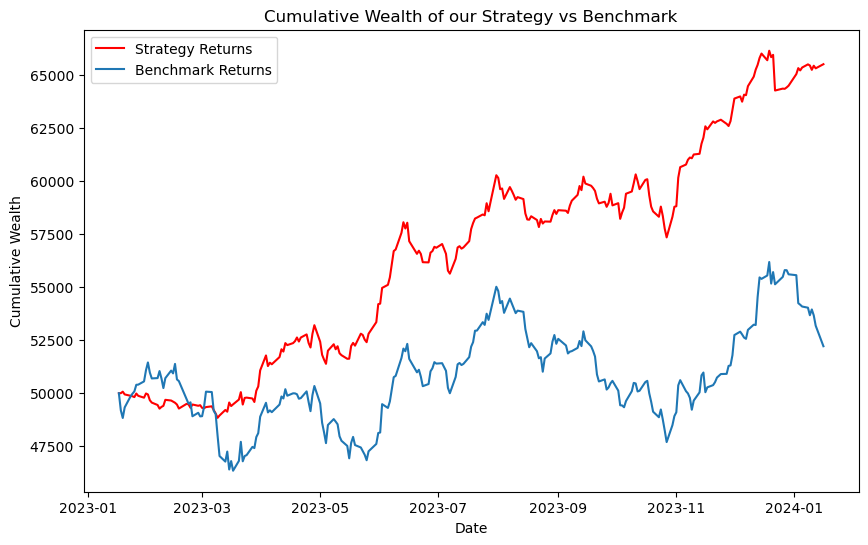

In [79]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title('Cumulative Wealth of our Strategy vs Benchmark')
plt.xlabel('Date') 
plt.ylabel('Cumulative Wealth')
plt.plot(test_strat_cumulative_wealth, label ='Strategy Returns', c = 'r')
ax1.legend(loc='upper left')
#ax2= ax1. twinx()
plt.plot(cumulative_wealth_benchmark_test, label = 'Benchmark Returns') 
plt.legend(loc='upper left')


### Cumulative wealth plot

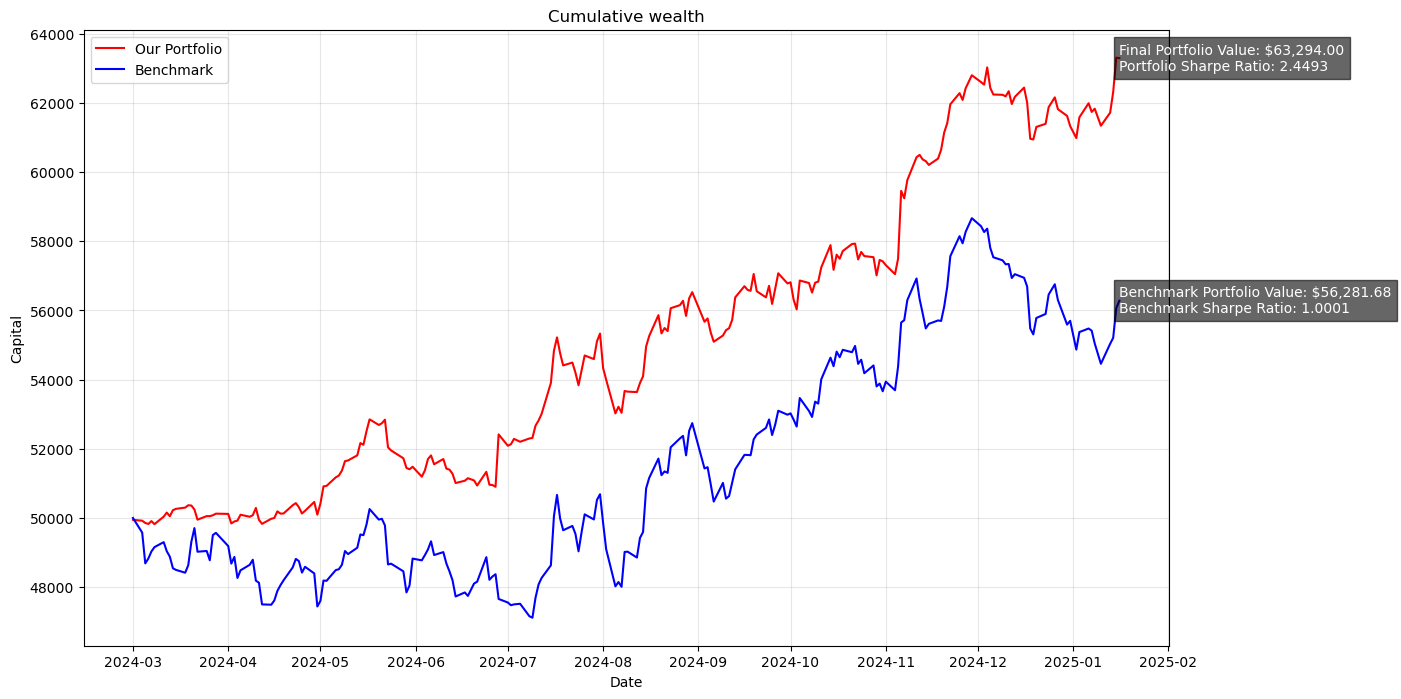

In [113]:
plt.figure(figsize=(14, 8))
plt.plot(cumulative_wealth, 'r', label = 'Our Portfolio')
plt.plot(benchmark_cumulative_wealth, 'b', label = 'Benchmark')
plt.title('Cumulative wealth')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()
last_x = cumulative_wealth.index[-1]
plt.text(x=last_x, 
         y=final_port_value,
         s=f"Final Portfolio Value: ${final_port_value:,.2f}\nPortfolio Sharpe Ratio: {port_sharpe:.4f}",
         fontsize=10, color='white', ha='left', va='center',
         bbox=dict(facecolor='black', alpha=0.6))

plt.text(x=last_x, 
         y=final_benchmark_port_value,
         s=f"Benchmark Portfolio Value: ${final_benchmark_port_value:,.2f}\nBenchmark Sharpe Ratio: {benchmark_port_sharpe:.4f}",
         fontsize=10, color='white', ha='left', va='center',
         bbox=dict(facecolor='black', alpha=0.6))

plt.grid(alpha=0.3)
plt.show()

### Individual stocks returns

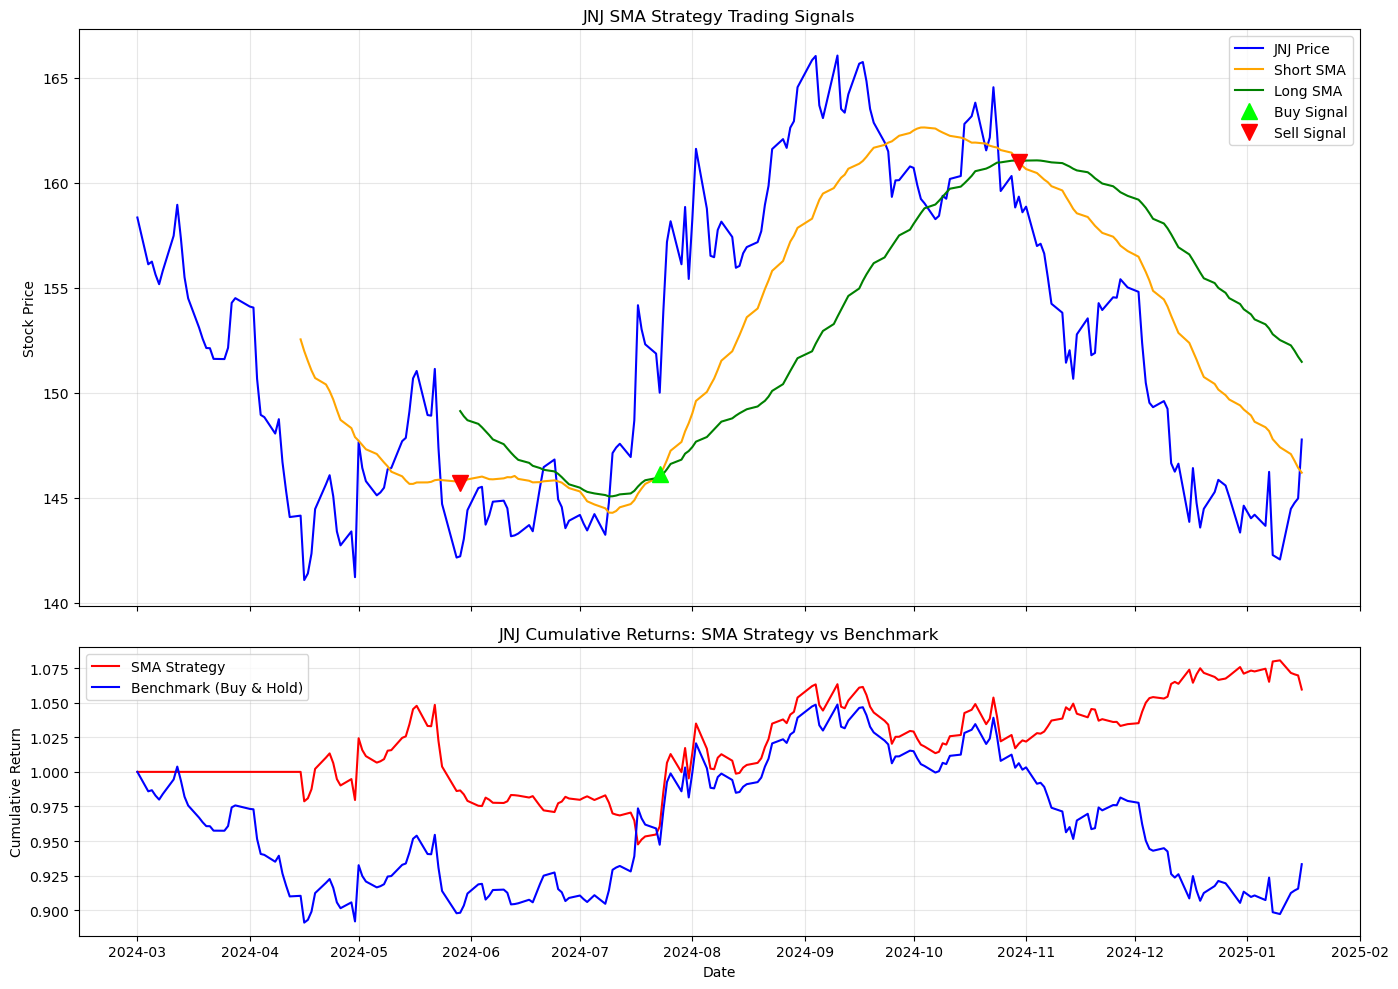

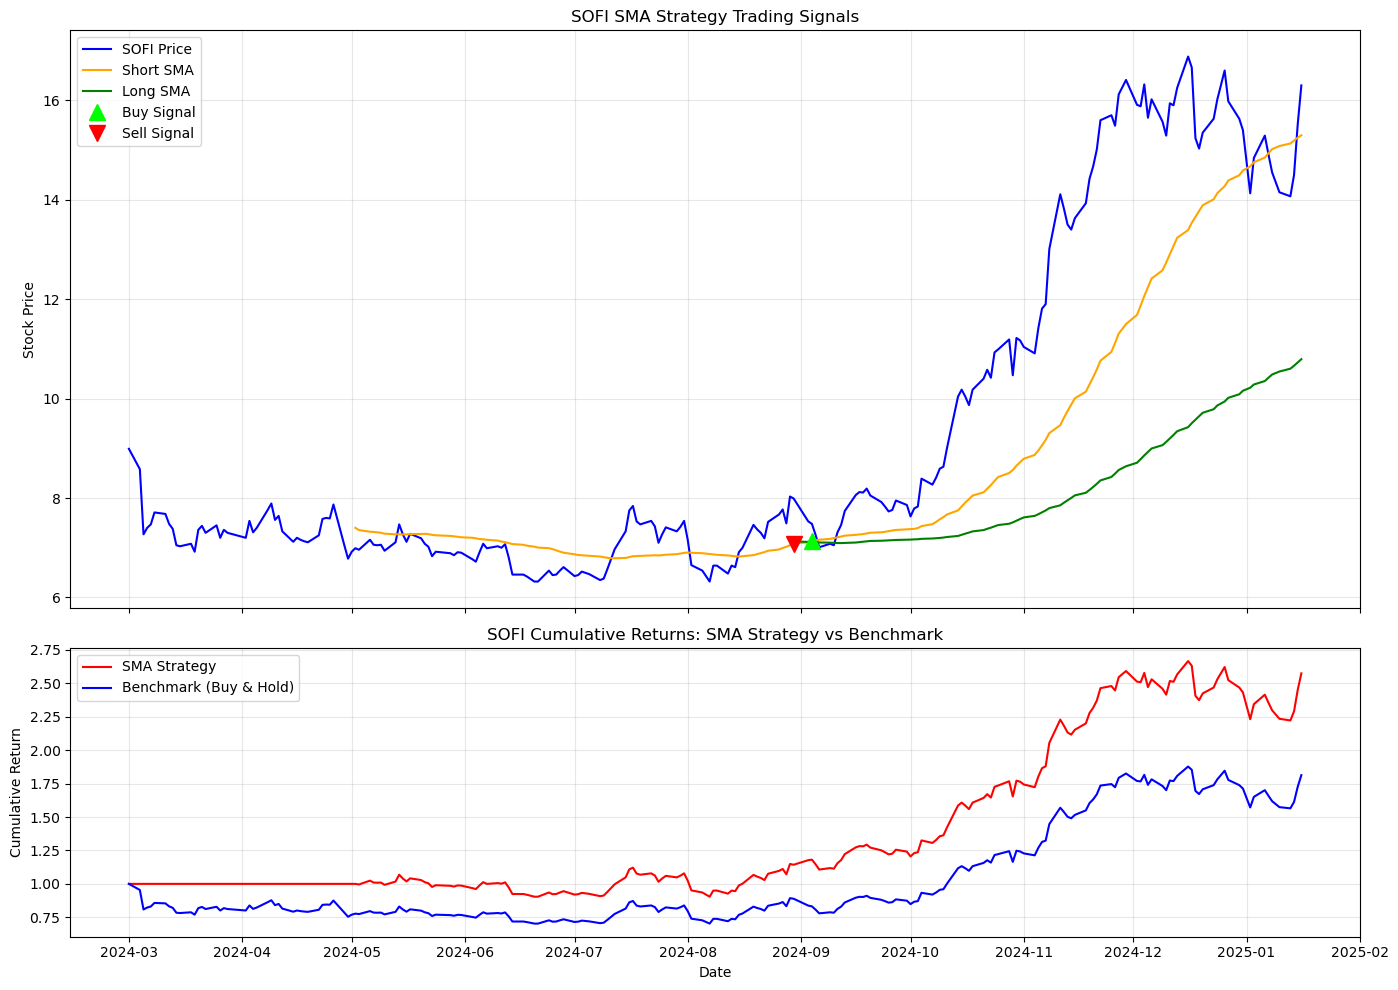

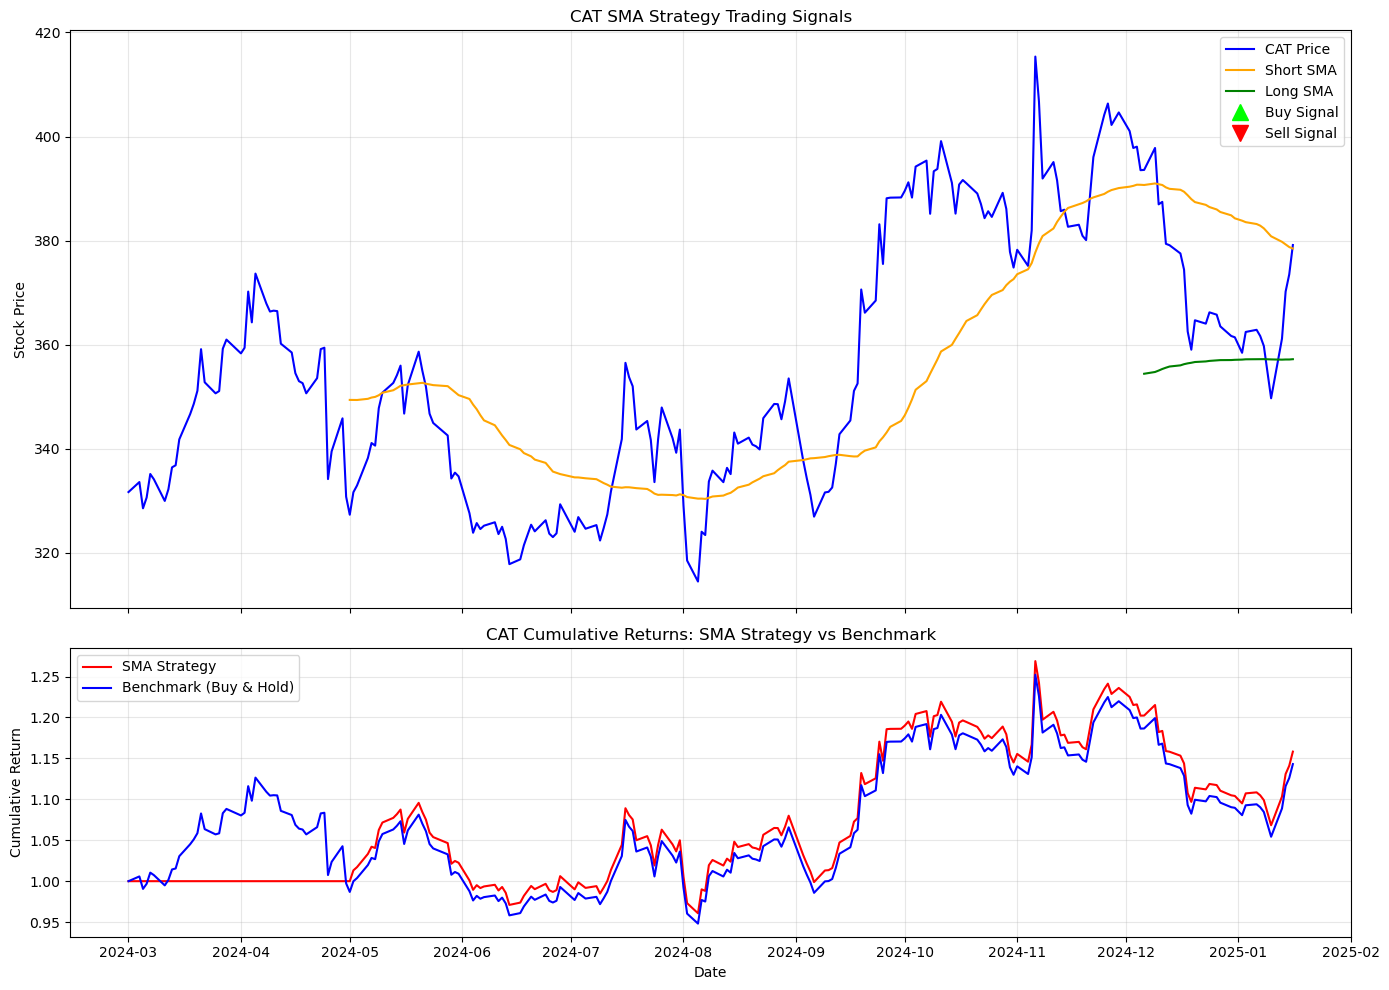

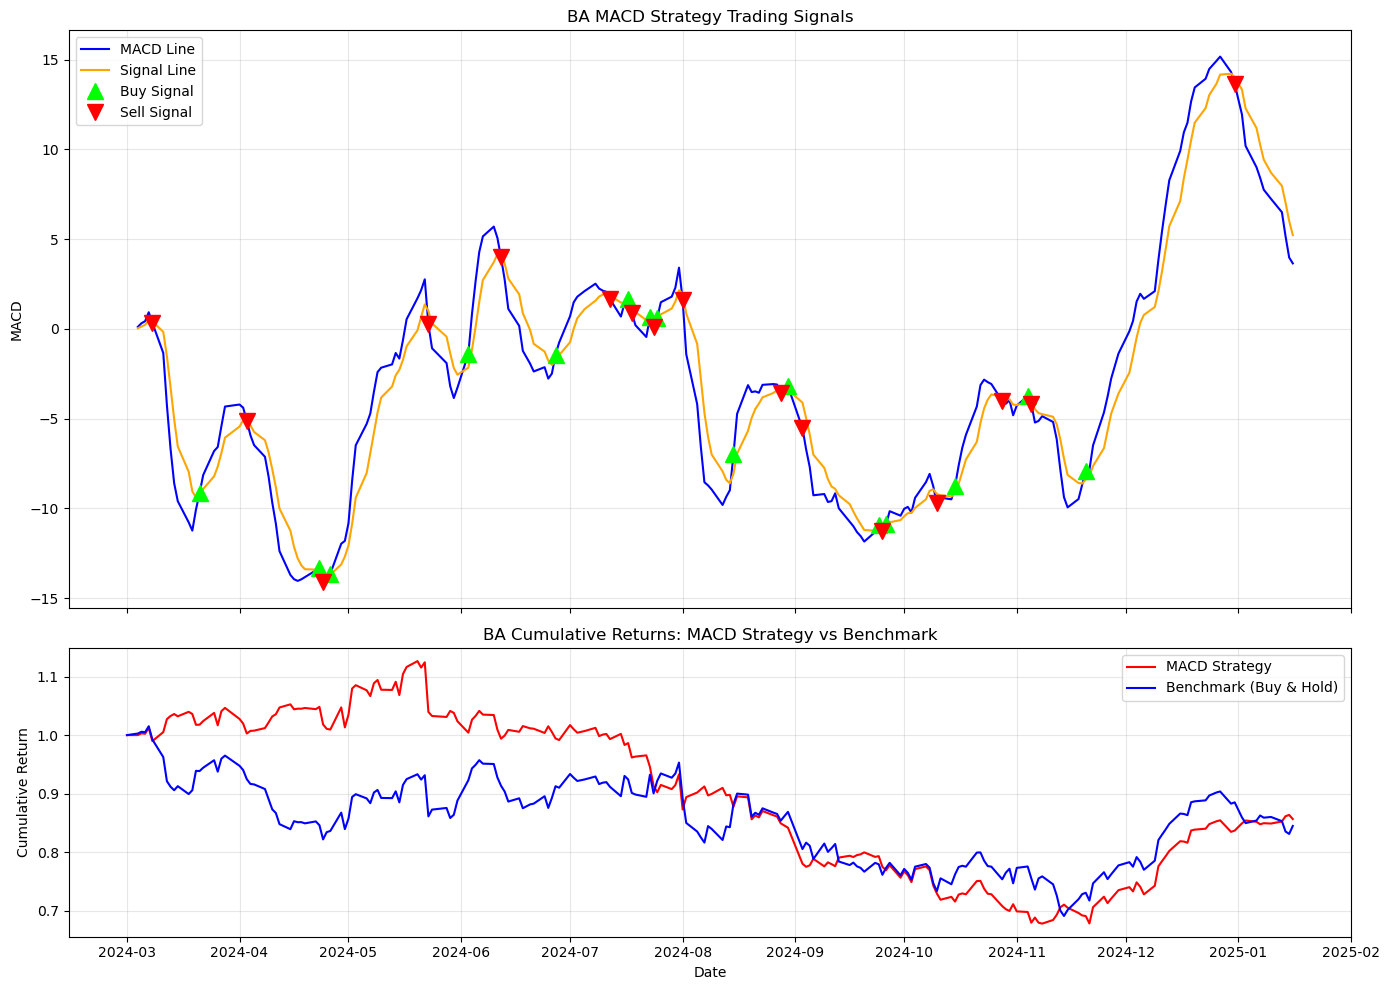

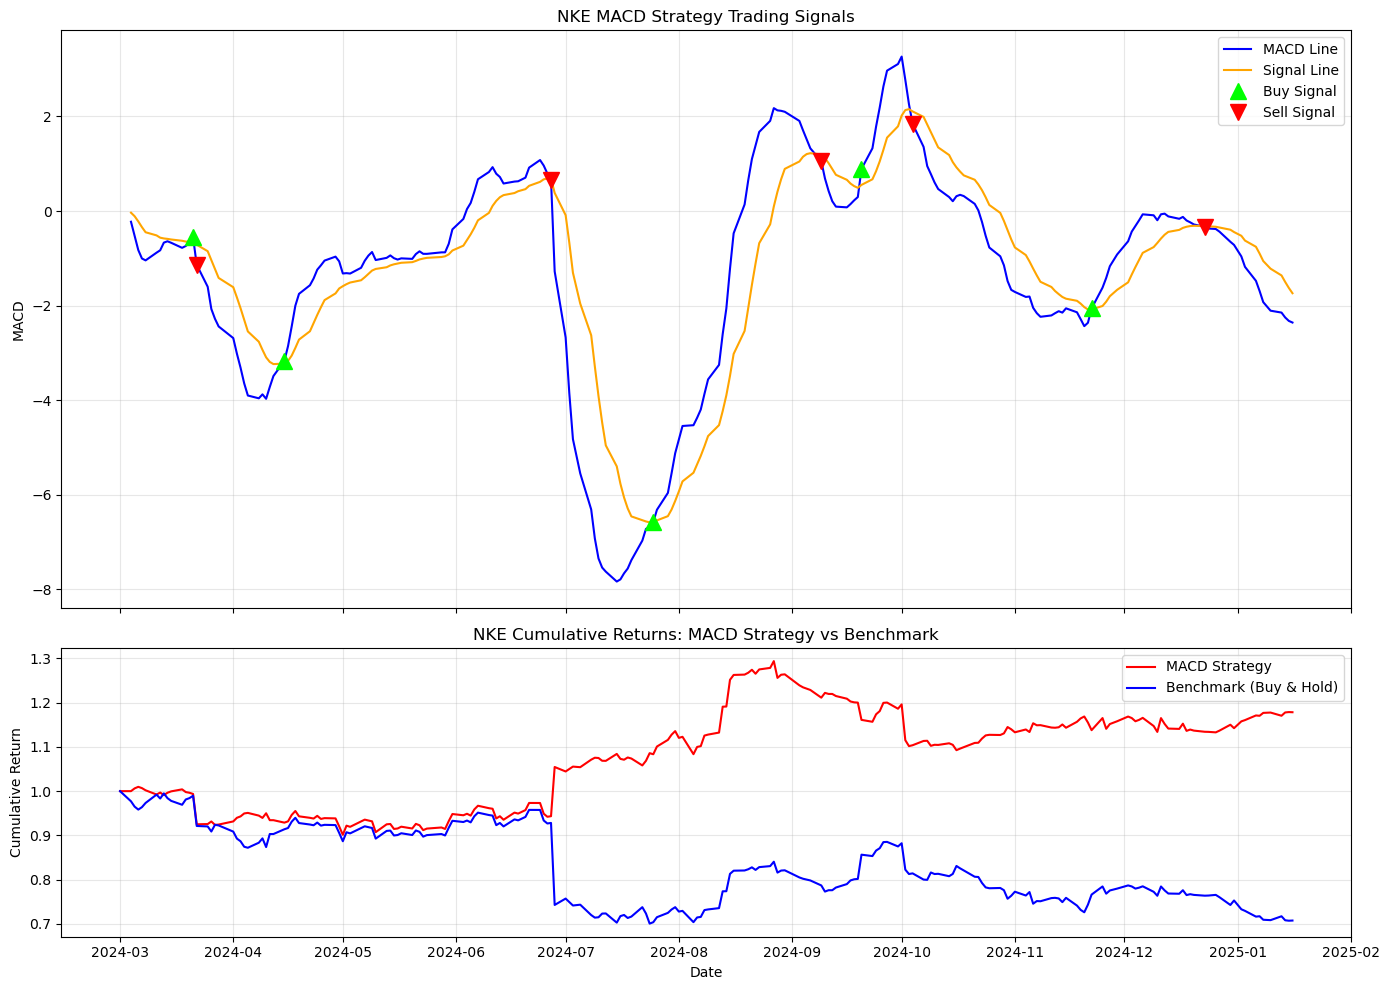

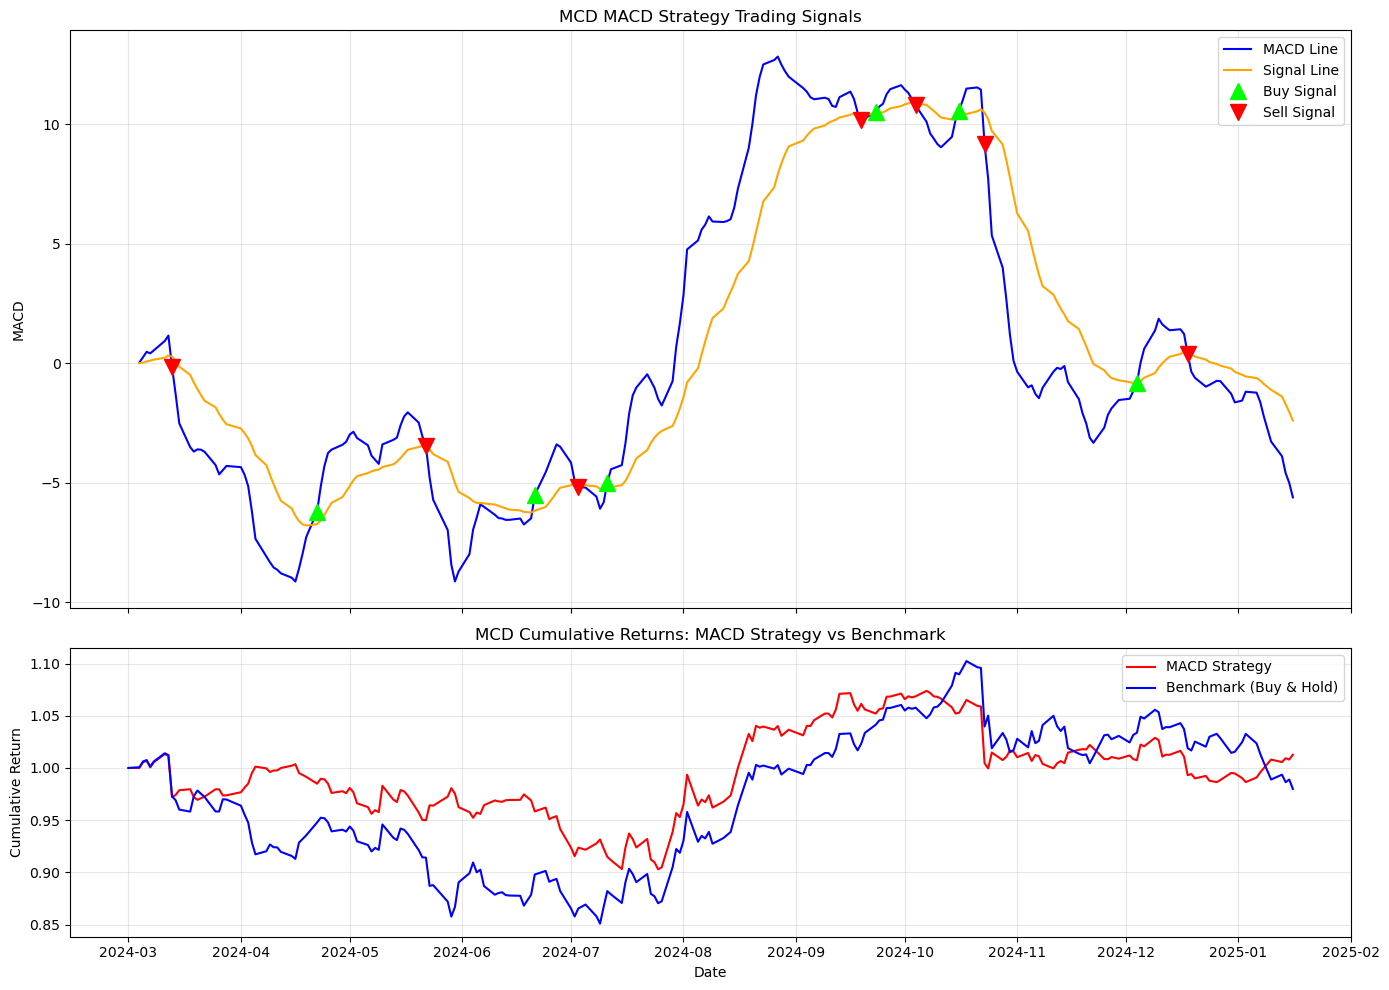

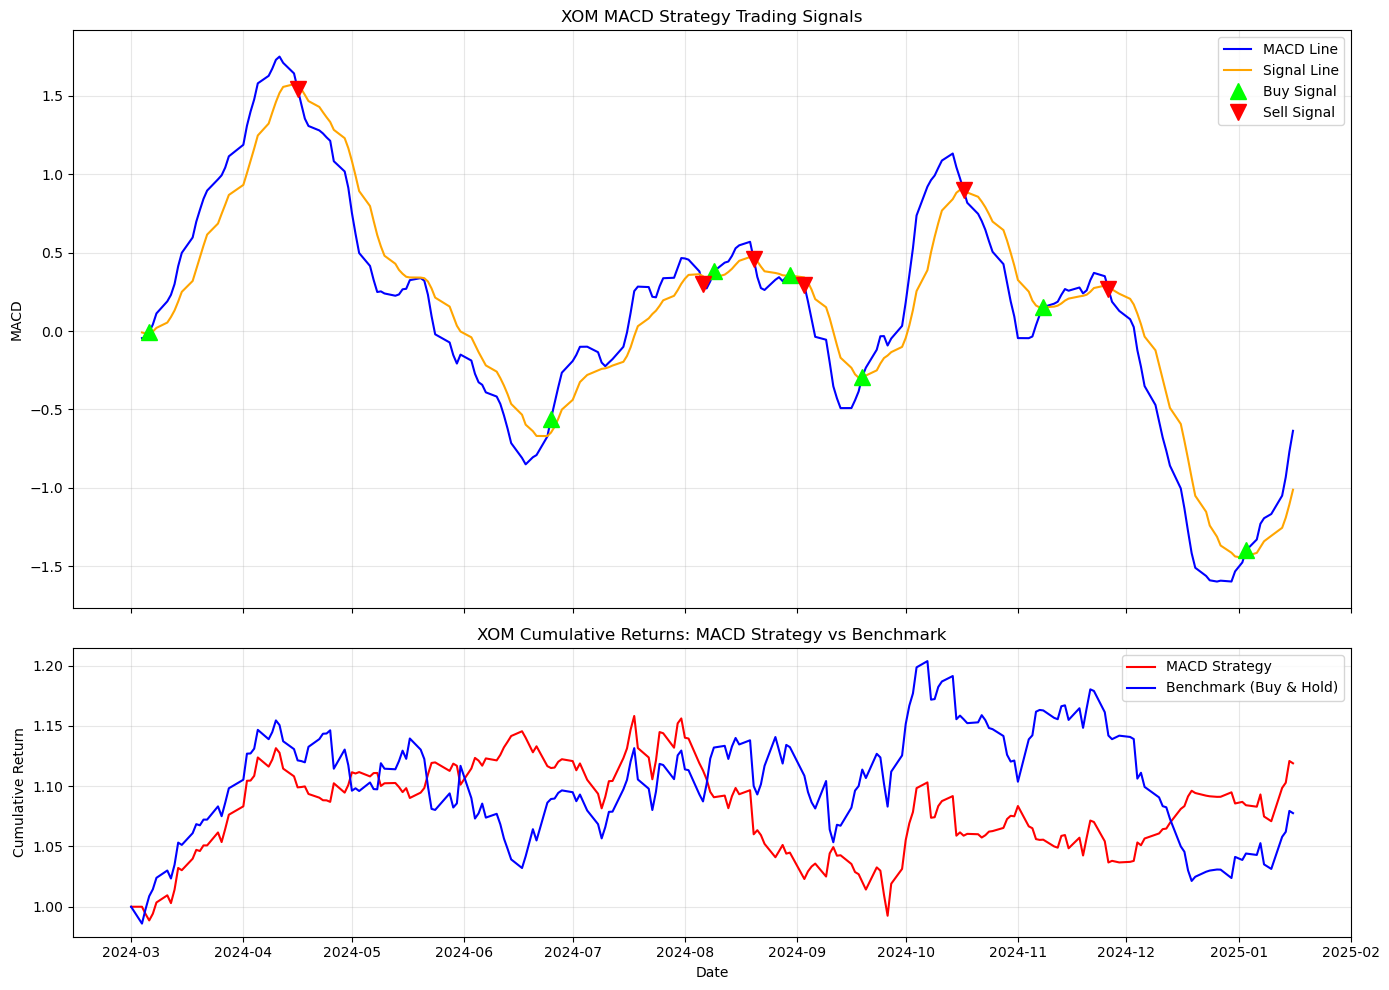

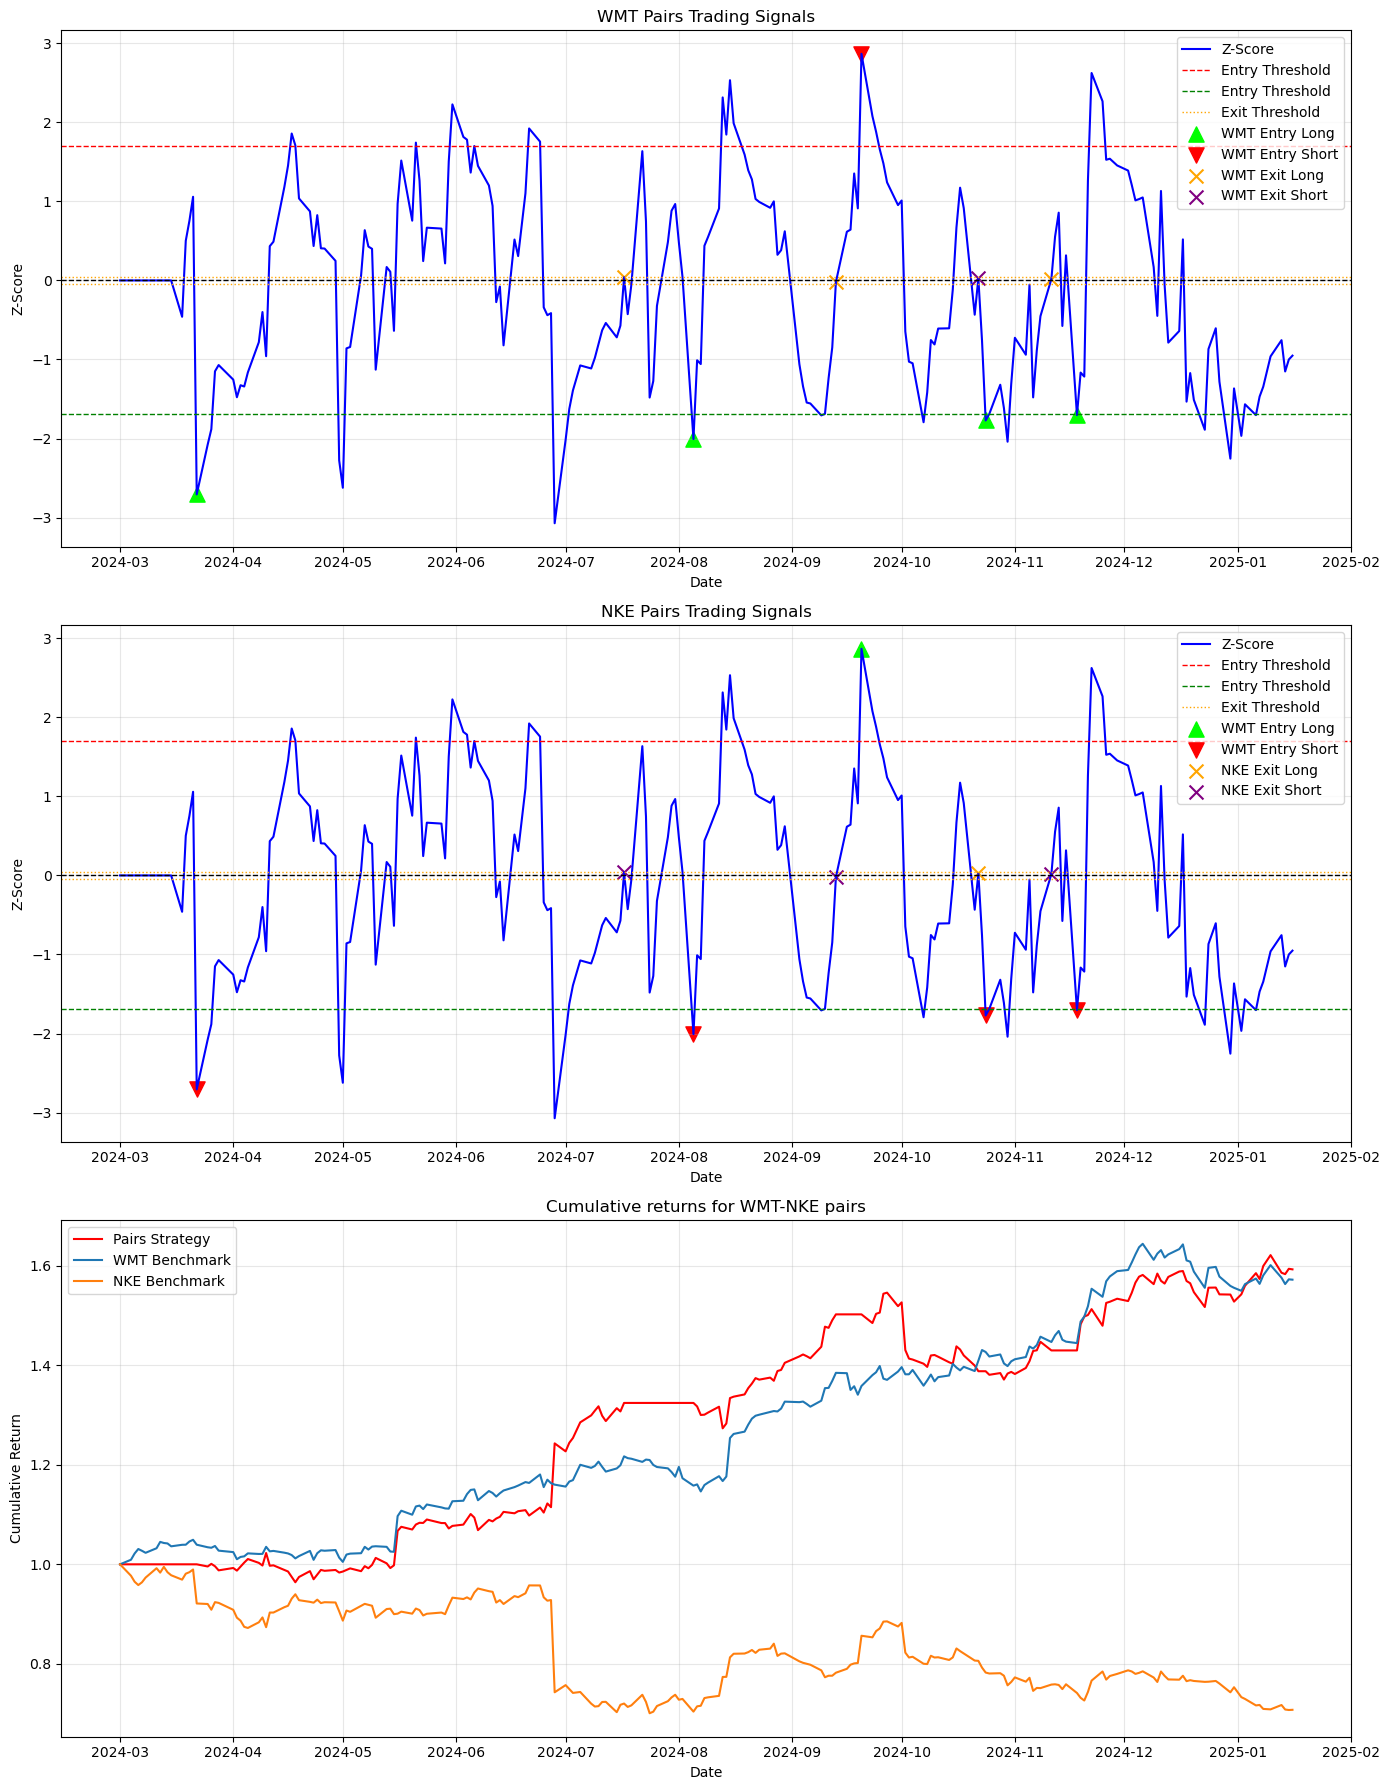

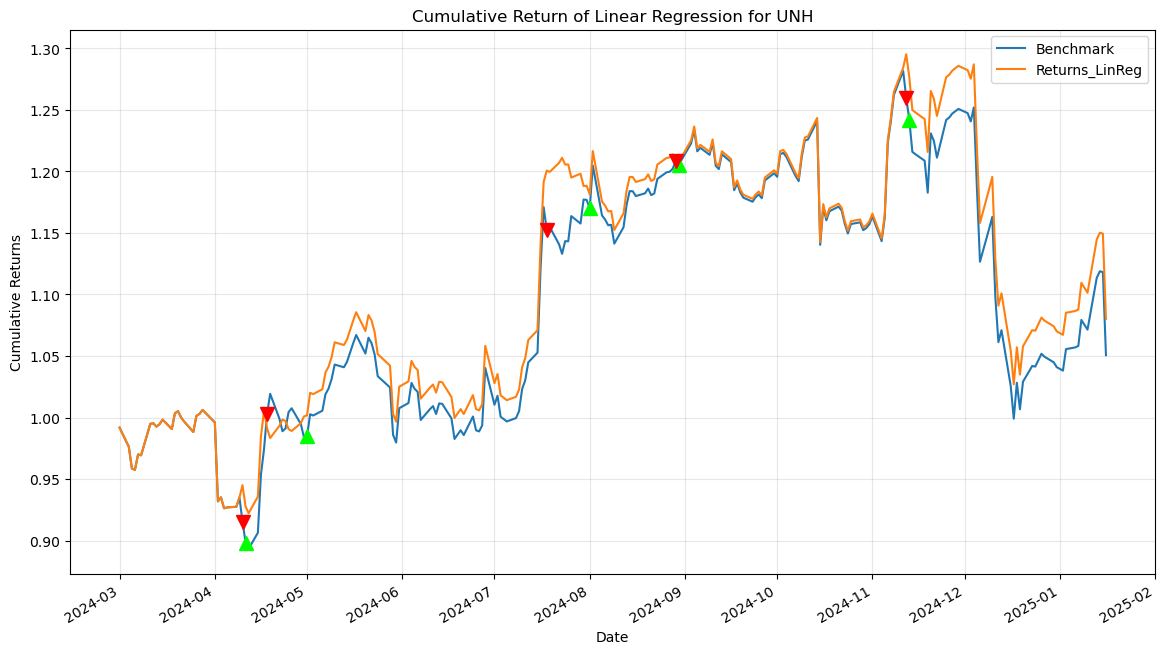

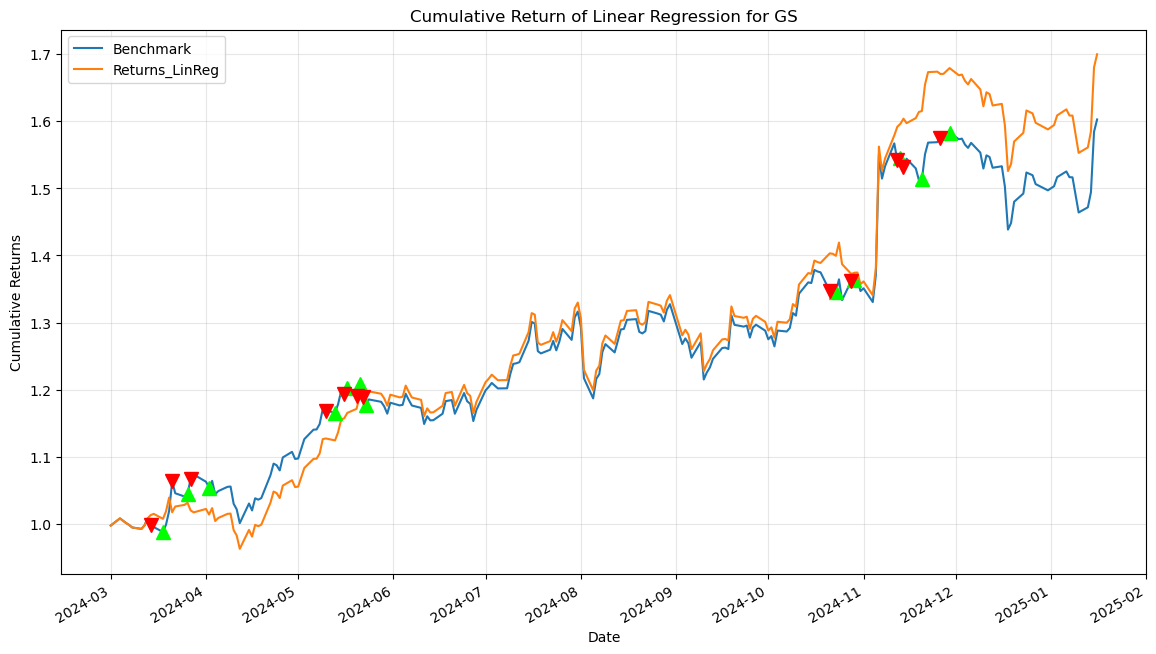

In [233]:
eq_cap = pd.DataFrame()
eq_cap.index = data.index
pairs_no_trade = pd.DataFrame() # stores whenever the pairs trading is not carrying out a trade
pairs_no_trade.index = data.index
for stock in port_SMA:
    sma_params = test_sma_all_best_params[stock] # optimised params on test period
    best_short, best_long = sma_params['best_short'], sma_params['best_long']
    _, stock_df = sma_strat(data, stock, best_short, best_long)
    plot_sma(stock_df, stock)
    # storing position
    signals = stock_df['Signal']
    eq_cap[str(stock)+'_SMA'] = signals

for stock in port_MACD:
    macd_params = test_macd_all_best_params[stock] # optimised params on test period
    best_fast, best_slow, best_signal = macd_params['best_fast'], macd_params['best_slow'], macd_params['best_signal']
    _, stock_df = macd_strat(data, stock, best_fast, best_slow, best_signal)
    plot_macd(stock_df, stock)
    # storing position
    signals = stock_df['Signal']
    eq_cap[str(stock)+'_MACD'] = signals

for pair in port_pairs:
    pair_params = test_pairs_all_best_params[pair] # optimised params on test period
    best_entry, best_exit, best_window = pair_params['best_entry'], pair_params['best_exit'], pair_params['best_window']
    _, pair_df = pairs_strat(data, pair, best_window, best_entry, best_exit)
    plot_pairs(pair_df, pair, best_entry, best_exit)
    # storing position
    pair_name = f"{pair[0]}_{pair[1]}"
    eq_cap[f"{pair[0]}_Pair_in_{pair_name}"] = pd.to_numeric(pair_df[f'{pair[0]} Position']/2)
    eq_cap[f"{pair[1]}_Pair_in_{pair_name}"] = pd.to_numeric(pair_df[f"{pair[1]} Position"]/2)
    pairs_no_trade[pair_name] = np.where(pair_df[f'{pair[0]} Position']==0, 1, 0)

for stock in port_LR:
    ret, mean_acc,pred = lin_reg_strat(data1, volume, stock,'2024-02-29', '2024-03-01', sliding_window_linear_reg, features, plot=True)
    eq_cap[str(stock)+ '_LR'] = pred

## Trading Actions

In [50]:
trading_actions = pd.DataFrame()
trading_actions.index = eq_cap.index
date_len = len(eq_cap)

for strat in eq_cap.columns:
    curr_stock = eq_cap[strat].values
    buy_indices = np.where((curr_stock[:-1] <= 0) & (curr_stock[1:] > 0))[0] + 1
    long_to_neut_indices = np.where((curr_stock[:-1] > 0) & (curr_stock[1:] == 0))[0] + 1
    sell_indices = np.where((curr_stock[:-1] >= 0)& (curr_stock[1:] < 0))[0] + 1
    short_to_neut_indices = np.where((curr_stock[:-1] < 0) & (curr_stock[1:] == 0))[0] + 1
    trading_actions[strat] = np.zeros(date_len)
    trading_actions.loc[trading_actions.index[buy_indices], strat]= 1
    trading_actions.loc[trading_actions.index[long_to_neut_indices], strat]= -0.5
    trading_actions.loc[trading_actions.index[sell_indices], strat]= -1
    trading_actions.loc[trading_actions.index[short_to_neut_indices], strat]= 0.5

In [51]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(trading_actions)

# 1 indicates shift from neutral/ short position to long position
# -1 indicates shift from neutral/ long position to short position
# 0.5 indicates shift from short position to neutral position (occurs in pairs trading)
# - 0.5 indicates shift from long position to neutral position (occurs in pairs trading)
# neutral position means that no position in taken on the stock (as per each strategy)

,JNJ_SMA,SOFI_SMA,CAT_SMA,BA_MACD,NKE_MACD,MCD_MACD,XOM_MACD,WMT_Pair_in_WMT_NKE,NKE_Pair_in_WMT_NKE,UNH_LR,GS_LR
Date,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-04,0.0,0.0,0.0,1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0
2024-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2024-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-08,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-13,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0


## Equity positions and Uninvested Capitals

In [53]:
eq_cap = eq_cap * 5000 # strategies equally weighted, capital for pairs trading already equally split between the 2 stocks

In [54]:
eq_cap['Strats_at_Zero_Position'] = eq_cap.eq(0).sum(axis=1) - pairs_no_trade.sum(axis=1)
eq_cap['Uninvested_Capital'] = eq_cap['Strats_at_Zero_Position']* 50000 * 1/num_assets

In [55]:
eq_cap

,JNJ_SMA,SOFI_SMA,CAT_SMA,BA_MACD,NKE_MACD,MCD_MACD,XOM_MACD,WMT_Pair_in_WMT_NKE,NKE_Pair_in_WMT_NKE,UNH_LR,GS_LR,Strats_at_Zero_Position,Uninvested_Capital
Date,,,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000.0,8,40000.0
2024-03-04,0.0,0.0,0.0,5000.0,-2500.0,5000.0,-2500.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-05,0.0,0.0,0.0,5000.0,-2500.0,5000.0,-2500.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-06,0.0,0.0,0.0,5000.0,-2500.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-07,0.0,0.0,0.0,5000.0,-2500.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,4,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,-2500.0,5000.0,5000.0,-2500.0,-2500.0,-2500.0,5000.0,2500.0,-1250.0,5000.0,5000.0,0,0.0
2025-01-13,-2500.0,5000.0,5000.0,-2500.0,-2500.0,-2500.0,5000.0,2500.0,-1250.0,5000.0,5000.0,0,0.0
2025-01-14,-2500.0,5000.0,5000.0,-2500.0,-2500.0,-2500.0,5000.0,2500.0,-1250.0,5000.0,5000.0,0,0.0


In [56]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(eq_cap)

,JNJ_SMA,SOFI_SMA,CAT_SMA,BA_MACD,NKE_MACD,MCD_MACD,XOM_MACD,WMT_Pair_in_WMT_NKE,NKE_Pair_in_WMT_NKE,UNH_LR,GS_LR,Strats_at_Zero_Position,Uninvested_Capital
Date,,,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000.0,8,40000.0
2024-03-04,0.0,0.0,0.0,5000.0,-2500.0,5000.0,-2500.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-05,0.0,0.0,0.0,5000.0,-2500.0,5000.0,-2500.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-06,0.0,0.0,0.0,5000.0,-2500.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-07,0.0,0.0,0.0,5000.0,-2500.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-08,0.0,0.0,0.0,-2500.0,-2500.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-11,0.0,0.0,0.0,-2500.0,-2500.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-12,0.0,0.0,0.0,-2500.0,-2500.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,4,20000.0
2024-03-13,0.0,0.0,0.0,-2500.0,-2500.0,-2500.0,5000.0,0.0,0.0,5000.0,5000.0,4,20000.0


## Strategy for bonus marks?

In [58]:
# please run the whole file to get the stored values

In [59]:
def strategy(data_file, start_date):
    data = clean_data(data_file).iloc[:, :20].copy() # extract close prices from cleaned data
    data = data.loc['2024-03-01':] # trading period data
    stocks = list(set([col.split("_")[0] for col in data.columns]))
    stocks.sort()
    for stock in stocks:
        data.rename(columns={f'{stock}_Close': f'{stock}'}, inplace=True)